In [2]:
from google.colab import drive
drive.mount('/content/drive')


FOLDERNAME = '/Colab Notebooks/cs231n/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cs231n/assignment1/cs231n/datasets
/content/drive/My Drive/Colab Notebooks/cs231n/assignment1


# Overview
<!--
Within this notebook, I will:

implement a fully-vectorized loss function for the Softmax classifier
implement the fully-vectorized expression for its analytic gradient
check your implementation with numerical gradient
use a validation set to tune the learning rate and regularization strength
optimize the loss function with SGD
visualize the final learned weights

1.   Implement the Softmax Classifier.
2.   Implement the fully-vectorized expression for its analytic gradient.
3.   Check the implementation with numerical gradient.
4.   Use a validation set to tune the learning rate and regularization strength
5.   Optimize the loss function with SGD and visualize the final weights

 -->


In [4]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [5]:
#Load the raw CIFAR 10 dataset
cifar_10_dir = 'cs231n/datasets/cifar-10-batches-py'

try:
  del X_train, y_train
  del X_test, y_test
  print('Cleared previously loaded data')
except:
  pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar_10_dir)

print("Training data shape:", X_train.shape)

Training data shape: (50000, 32, 32, 3)


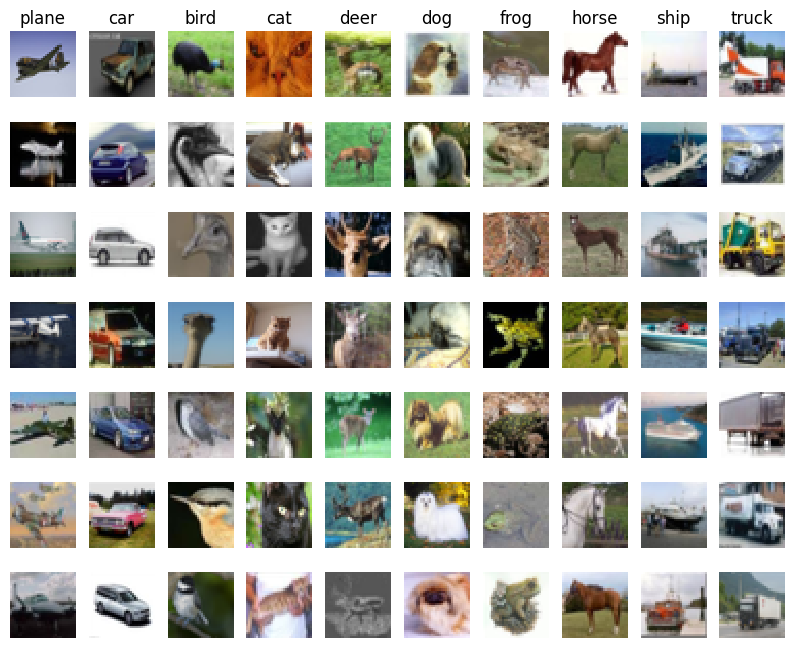

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [12]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  #Load the CIFAR 10 dataset and perform preprocessing to prepare it for the linear classifier

  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

  #Cleaning up variables
  try:
    del X_train, y_train
    del X_test, y_test
    print('Cleaned up variables')
  except:
    pass

  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

  #Subsample the data
  mask = list(range(num_training, num_training + num_validation))
  X_val = X_train[mask]
  y_val = y_train[mask]

  mask = list(range(num_training))
  X_train = X_train[mask]
  y_train = y_train[mask]

  mask = list(range(num_test))
  X_test = X_test[mask]
  y_test = y_test[mask]

  #Preprocess; reshape the input data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))

  #normalize the data; subtract the mean image
  mean_image = np.mean(X_train, axis=0),
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image

  #Add the bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

  return X_train, y_train, X_val, y_val, X_test, y_test

# Use the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)


In [8]:
def compute_distance(X_train, X_test):
  #Calculate the fully vectorized L2 dist btw each test point & all training points
  test_squared = np.sum(X_test ** 2, axis=1, keepdims=True)
  train_squared = np.sum(X_train ** 2, axis=1)
  cross_term = X_test.dot(X_train.T)
  dists = np.sqrt(test_squared - 2 * cross_term + train_squared) #sum of the difference of two squares
  return dists

In [9]:
def predict_labels(dists, y_train, k=1):
  #Predict labels for the data using the distance matrix
  num_test = dists.shape[0]
  y_pred = np.zeros(num_test, dtype=int)

  for i in range(num_test):
    closest_y = y_train[np.argsort(dists[i])[:k]]
    y_pred[i] = np.bincount(closest_y).argmax()
  return y_pred

In [15]:
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
results = {}
best_val_acc = -1
best_k = None

dists_val = compute_distance(X_train, X_val)

for k in k_choices:
    y_val_pred = predict_labels(dists_val, y_train, k=k)
    val_acc = np.mean(y_val_pred == y_val)
    results[k] = val_acc

    print(f'k = {k}, validation accuracy = {val_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_k = k

print(f'\nBest k = {best_k}, accuracy = {best_val_acc:.4f}')

k = 1, validation accuracy = 0.3570
k = 3, validation accuracy = 0.3270
k = 5, validation accuracy = 0.3260
k = 8, validation accuracy = 0.3170
k = 10, validation accuracy = 0.3160
k = 12, validation accuracy = 0.3130
k = 15, validation accuracy = 0.3080
k = 20, validation accuracy = 0.3050
k = 50, validation accuracy = 0.2890
k = 100, validation accuracy = 0.2860

Best k = 1, accuracy = 0.3570


In [17]:
dists_test = compute_distance(X_train, X_test)
y_test_pred = predict_labels(dists_test, y_train, k=best_k)
test_acc = np.mean(y_test_pred == y_test)
print("Test set accuracy: ", test_acc)

Test set accuracy:  0.346


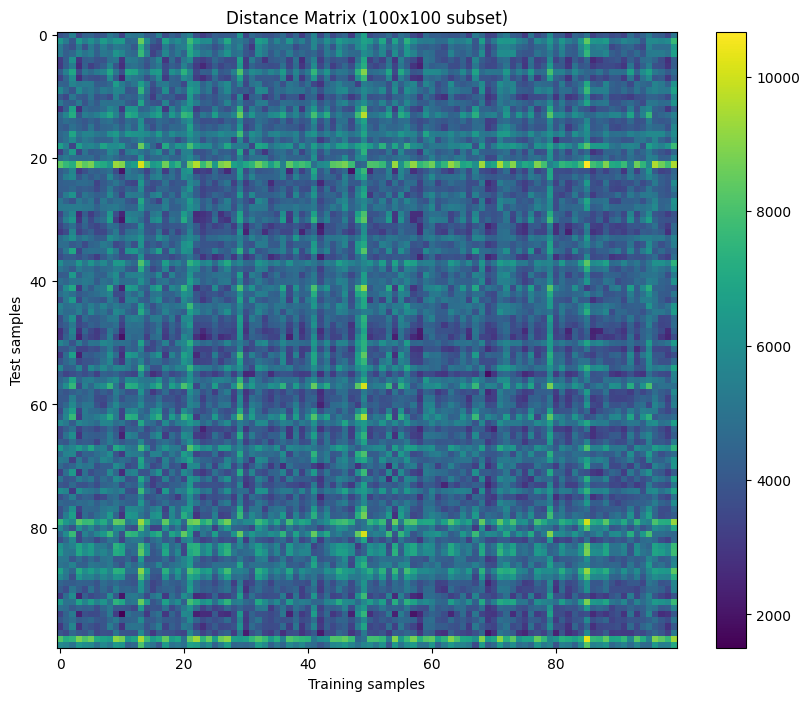

In [19]:
import matplotlib.pyplot as plt

plt.imshow(dists_test[:100, :100], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Distance Matrix (100x100 subset)')
plt.xlabel('Training samples')
plt.ylabel('Test samples')
plt.show()